In [1]:
!mkdir squad
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squad/dev-v2.0.json

mkdir: cannot create directory ‘squad’: File exists
--2021-11-27 22:35:24--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.110.153, 185.199.111.153, 185.199.109.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘squad/train-v2.0.json’

100%[======================================>] 42,123,633  78.5MB/s   in 0.5s   

2021-11-27 22:35:25 (78.5 MB/s) - ‘squad/train-v2.0.json’ saved [42123633/42123633]

--2021-11-27 22:35:25--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [ap

In [2]:
import json
from pathlib import Path

def read_squad(path):
    path = Path(path)
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    contexts = []
    questions = []
    answers = []
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)

    return contexts, questions, answers

train_contexts, train_questions, train_answers = read_squad('squad/train-v2.0.json')
val_contexts, val_questions, val_answers = read_squad('squad/dev-v2.0.json')

In [3]:
def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        gold_text = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        # sometimes squad answers are off by a character or two – fix this
        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1     # When the gold label is off by one character
        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2     # When the gold label is off by two characters

add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)


In [4]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)

In [5]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

In [6]:
import torch

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

In [7]:
from transformers import DistilBertForQuestionAnswering
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

In [8]:
## PYTORCH CODE
from torch.utils.data import DataLoader
from transformers import AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)
loss_values = []
for epoch in range(3):
    running_loss = 0.0
    for i ,batch in enumerate(train_loader,0):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        loss.backward()
        optim.step()

        running_loss += loss.item()
            
        
        if i % 100 == 99:    # print every 2000 mini-batches
                
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                loss_values.append(running_loss /100)
                running_loss = 0.0
       


[1,   100] loss: 3.938
[1,   200] loss: 2.556
[1,   300] loss: 1.881
[1,   400] loss: 1.743
[1,   500] loss: 1.586
[1,   600] loss: 1.581
[1,   700] loss: 1.486
[1,   800] loss: 1.473
[1,   900] loss: 1.394
[1,  1000] loss: 1.372
[1,  1100] loss: 1.380
[1,  1200] loss: 1.398
[1,  1300] loss: 1.339
[1,  1400] loss: 1.368
[1,  1500] loss: 1.356
[1,  1600] loss: 1.294
[1,  1700] loss: 1.278
[1,  1800] loss: 1.270
[1,  1900] loss: 1.266
[1,  2000] loss: 1.216
[1,  2100] loss: 1.272
[1,  2200] loss: 1.220
[1,  2300] loss: 1.232
[1,  2400] loss: 1.242
[1,  2500] loss: 1.239
[1,  2600] loss: 1.187
[1,  2700] loss: 1.203
[2,   100] loss: 0.902
[2,   200] loss: 0.907
[2,   300] loss: 0.917
[2,   400] loss: 0.890
[2,   500] loss: 0.930
[2,   600] loss: 0.905
[2,   700] loss: 0.911
[2,   800] loss: 0.914
[2,   900] loss: 0.919
[2,  1000] loss: 0.896
[2,  1100] loss: 0.934
[2,  1200] loss: 0.920
[2,  1300] loss: 0.937
[2,  1400] loss: 0.914
[2,  1500] loss: 0.939
[2,  1600] loss: 0.945
[2,  1700] 

Finished Training Trainset


DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            

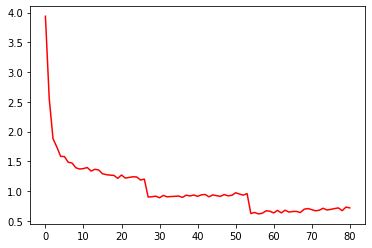

In [9]:
import matplotlib.pyplot as plt
import numpy as np

print('Finished Training Trainset')
            
plt.plot(np.array(loss_values), 'r')

model.eval()

In [13]:
PATH = './zimin1st.pth'
torch.save(model.state_dict(), PATH)

In [17]:
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

In [18]:
model.load_state_dict(torch.load(PATH))
model.eval()

DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            

In [19]:
# val_dataset[1300]
# batch['input_ids']
number = 1450
print('context:',val_contexts[number])
print('question:', val_questions[number])
print('ANS:',val_answers[number])

context: While BSkyB had been excluded from being a part of the ONdigital consortium, thereby making them a competitor by default, BSkyB was able to join ITV Digital's free-to-air replacement, Freeview, in which it holds an equal stake with the BBC, ITV, Channel 4 and National Grid Wireless. Prior to October 2005, three BSkyB channels were available on this platform: Sky News, Sky Three, and Sky Sports News. Initially BSkyB provided Sky Travel to the service. However, this was replaced by Sky Three on 31 October 2005, which was itself later re-branded as 'Pick TV' in 2011.
question: What was Sky Travel later rebranded as?
ANS: {'text': 'Pick TV', 'answer_start': 553, 'answer_end': 560}


In [33]:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [35]:
# from torch.utils.data import DataLoader
# val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
# for i ,batch in enumerate(val_loader,0):
#         # optim.zero_grad()
#         input_ids = batch['input_ids']
#         attention_mask = batch['attention_mask']
#         start_positions = batch['start_positions']
#         end_positions = batch['end_positions']
#         outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
#         answer_start = torch.argmax(outputs[1])
#         answer_end = torch.argmax(outputs[2]) +1
#         answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

number = 1450
batch = val_dataset[number]
input_ids = batch['input_ids']
# attention_mask = batch['attention_mask']
# start_positions = batch['start_positions']
# end_positions = batch['end_positions']
context = val_contexts[number]
question = val_questions[number]
inputs = tokenizer.encode_plus(question, context, return_tensors='pt')
# outputs = model(input_ids, attention_mask)
outputs = model(**inputs)
# outputs
answer_start = torch.argmax(outputs[0])
answer_end = torch.argmax(outputs[1]) +1
answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
# answer = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end])
print('Ground truth:', val_answers[number]['text'])
print('Prediction:',answer)

Ground truth: Pick TV
Prediction: ' pick tv


In [37]:
number = 1500
batch = val_dataset[number]
input_ids = batch['input_ids']
context = val_contexts[number]
question = val_questions[number]
inputs = tokenizer.encode_plus(question, context, return_tensors='pt')
# outputs = model(input_ids, attention_mask)
outputs = model(**inputs)
# outputs
answer_start = torch.argmax(outputs[0])
answer_end = torch.argmax(outputs[1]) +1
answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
# answer = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end])
print('Ground truth:', val_answers[number]['text'])
print('Prediction:',answer)

Ground truth: July 2013
Prediction: july 2013
